In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch.nn.functional as F
sys.path.append("/home/sukyeong/Project/DL_Assignment2/")

import torch
from torch import nn
from model.resnet import ResNet18,ResNet34,ResNet50
from model.vgg import VGG16,VGG19
from utils import get_loaders, evaluate_standard

### Feature Map

Files already downloaded and verified
Files already downloaded and verified


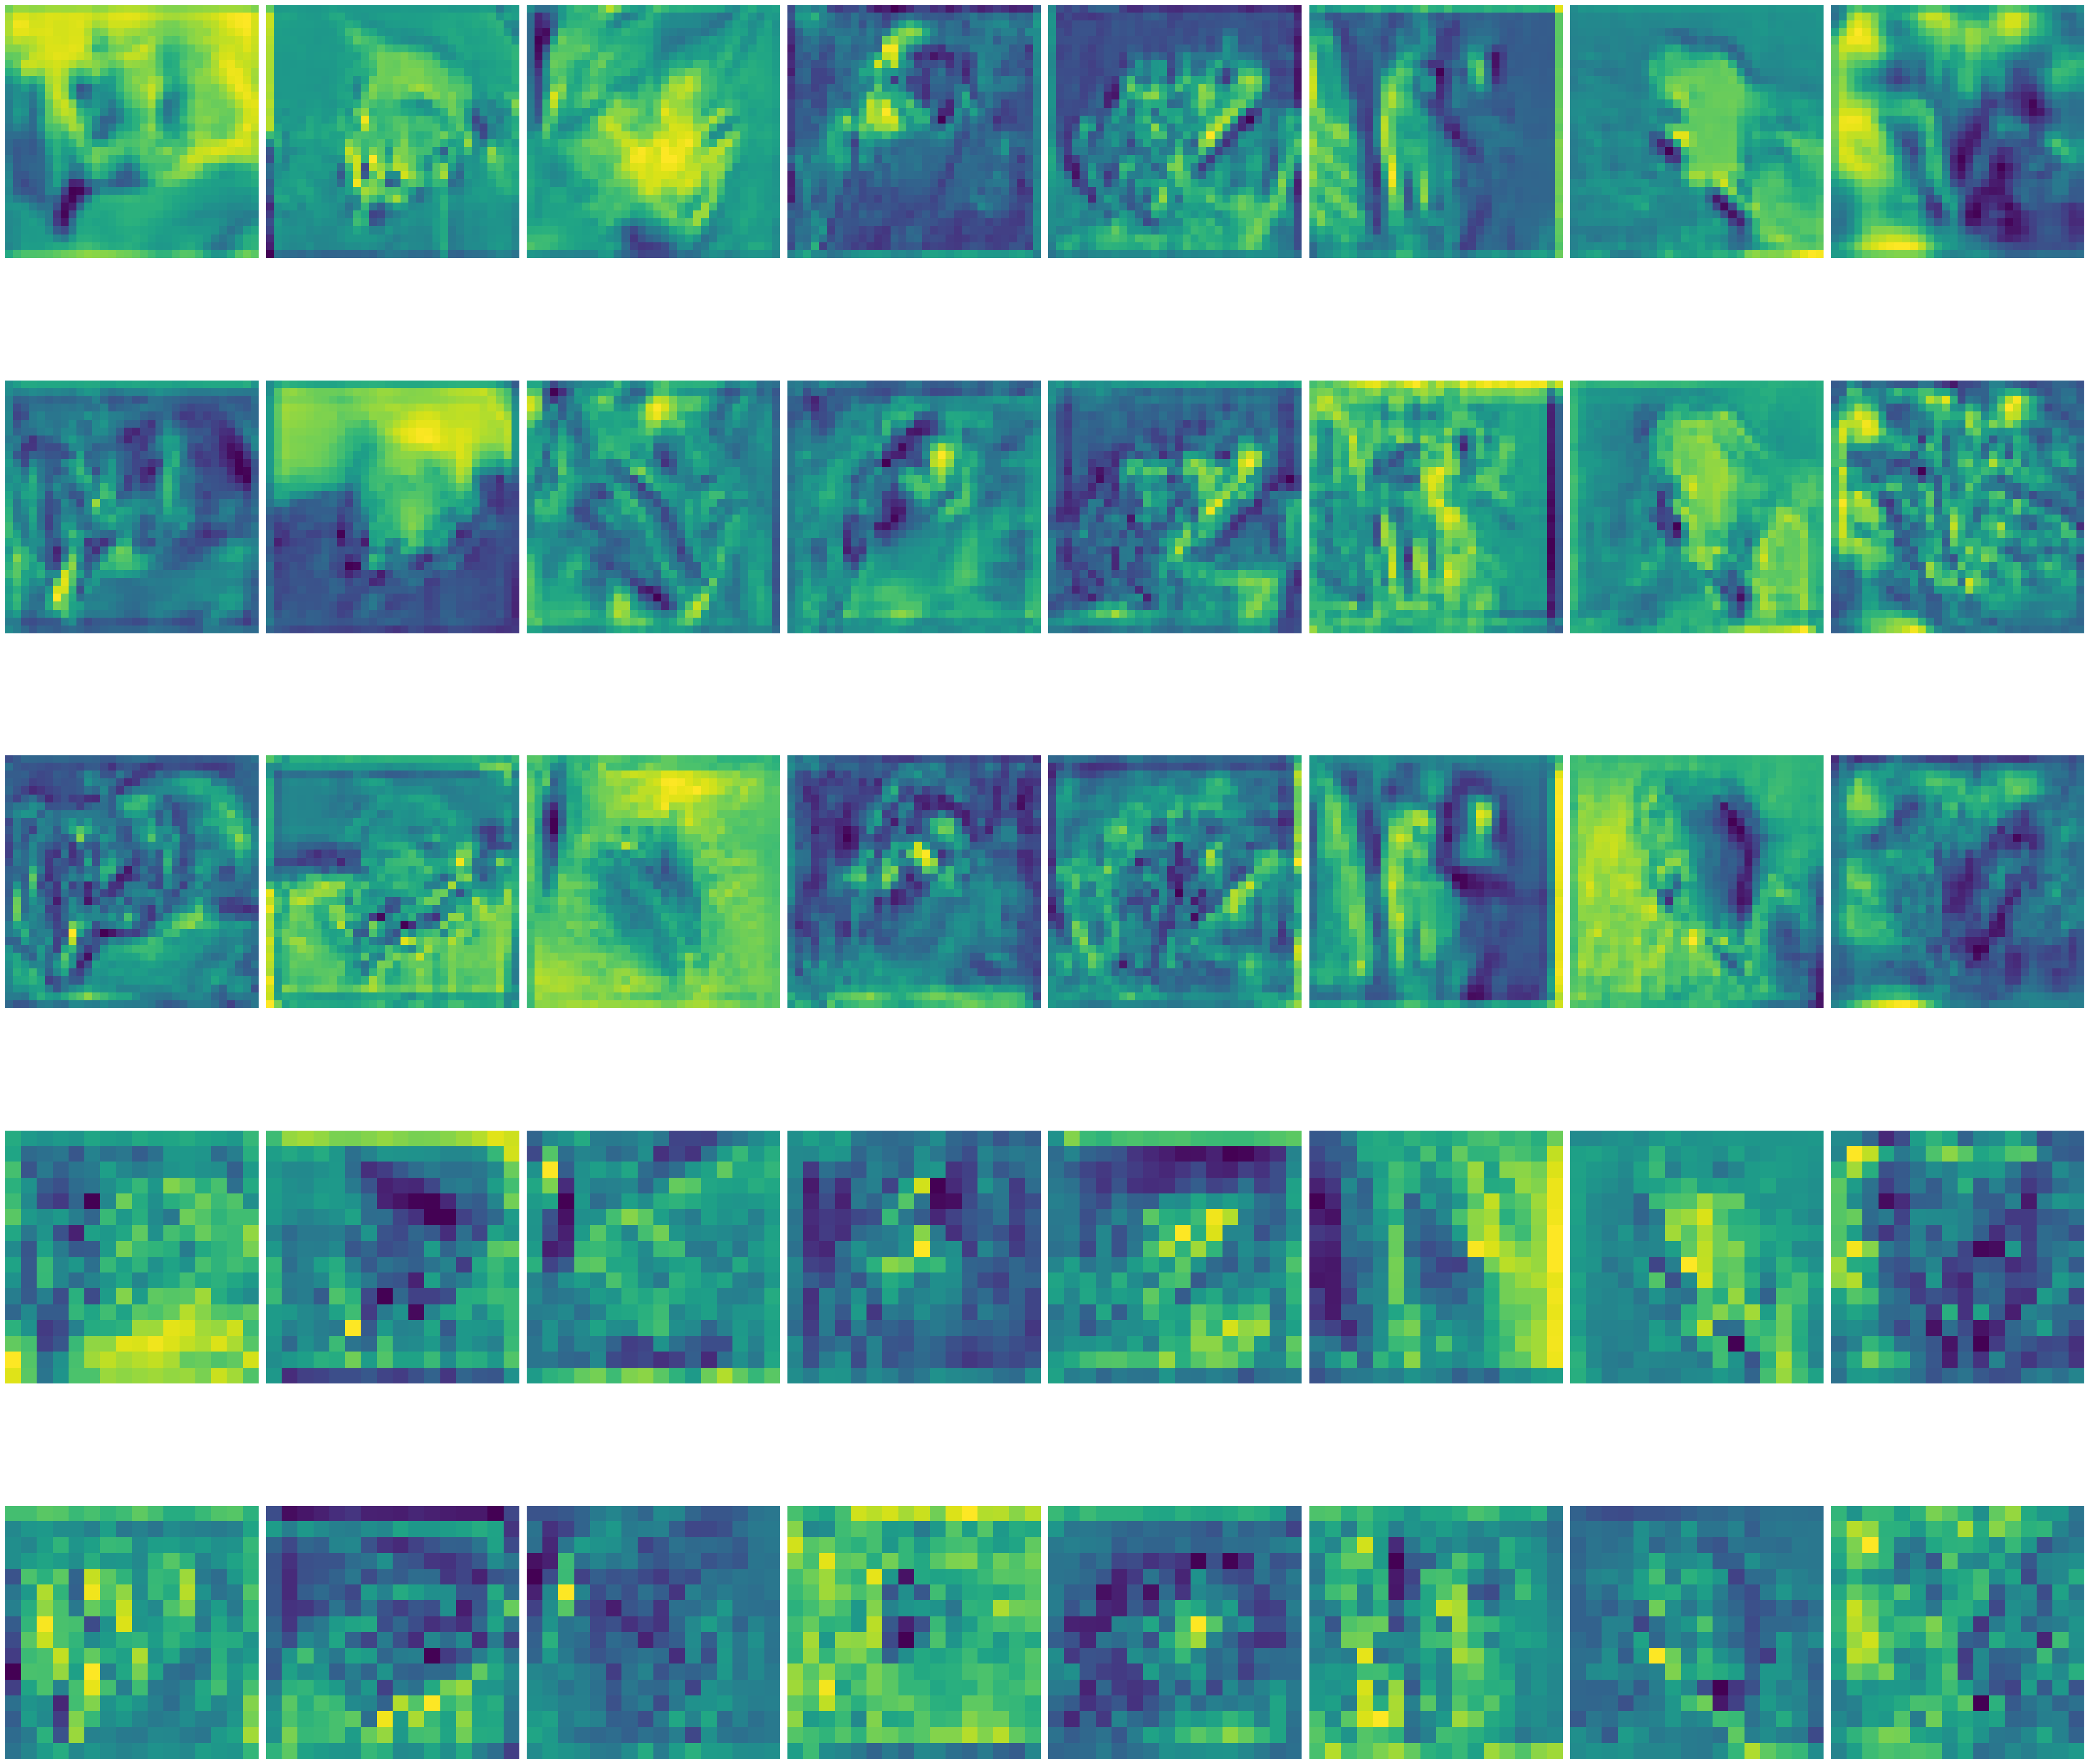

In [2]:
import torch
import matplotlib.pyplot as plt
import random
model = ResNet18(residual=True, num_classes=10).to("cuda")

train_loader, val_loader, _ = get_loaders(
    dir_="/home/sukyeong/Project/DL_Assignment2/data", 
    batch_size=128, 
    dataset="cifar10", 
    worker=4, 
    augs="", 
    validation=False
)



def visualize_feature_map_grid(model, input_images, num_layers=10, num_samples=8):
    selected_layers = [0, 2, 4, 6, 8]  # Specify the layers to visualize
    activations_per_layer = [[] for _ in range(num_layers)]

    def create_hook(activations_list):
        def hook(module, input, output):
            activations_list.append(output)
        return hook

    hooks = []
    conv_layers = []

    # Traverse the model to get all convolutional layers
    for layer in model.modules():
        if isinstance(layer, torch.nn.Conv2d):
            conv_layers.append(layer)

    # Register hooks for the selected convolutional layers
    for i in selected_layers:
        if i < len(conv_layers):  # Ensure the layer exists
            hook_handle = conv_layers[i].register_forward_hook(create_hook(activations_per_layer[i]))
            hooks.append(hook_handle)

    model.eval()
    with torch.no_grad():
        for img in input_images[:num_samples]:
            model(img.unsqueeze(0).to('cuda'))  # Forward pass for each sample

    # Create a grid for the selected layers only
    fig, axes = plt.subplots(len(selected_layers), num_samples, figsize=(40, 40))
    # fig.suptitle("Feature Maps of Selected Conv Layers (10 Different Samples)", fontsize=16)


    # Visualize random channel feature maps for each selected layer and sample
    for layer_idx, layer in enumerate(selected_layers):
        for sample_idx in range(num_samples):
            activation = activations_per_layer[layer][sample_idx]
            num_channels_available = activation.shape[1]
            random_channel = random.randint(0, num_channels_available - 1)

            axes[layer_idx, sample_idx].imshow(activation[0][random_channel].cpu().detach().numpy(), cmap='viridis')
            axes[layer_idx, sample_idx].axis('off')
            # if layer_idx == 0:
            #     axes[layer_idx, sample_idx].set_title(f"Sample {sample_idx + 1}", fontsize=12)
            # if sample_idx == 0:
            #     axes[layer_idx, sample_idx].set_ylabel(f"Layer {layer + 1}", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Remove hooks
    for hook_handle in hooks:
        hook_handle.remove()

# Extract the first 5 random samples from val_loader
input_images = []
for i, (image, _) in enumerate(val_loader):
    if len(input_images) >= 8:
        break
    input_images.append(image[0])  # Take one image from each batch

visualize_feature_map_grid(model, input_images)

### Network performance

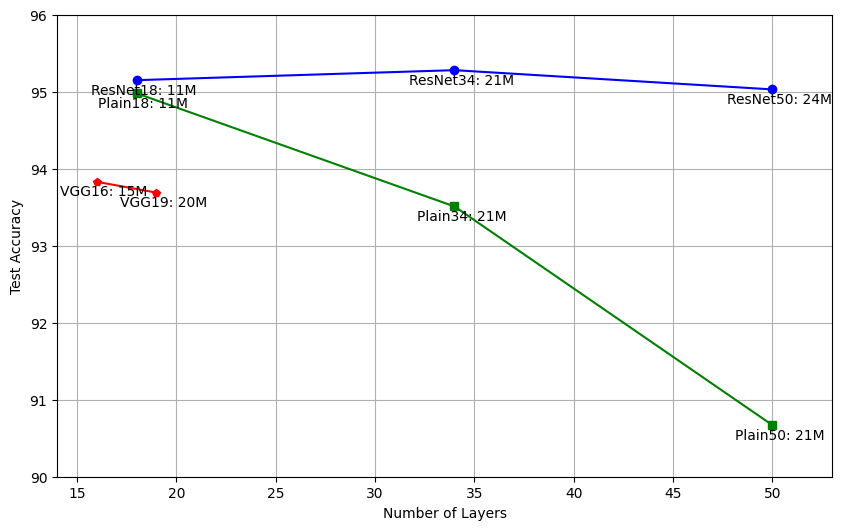

In [3]:
import matplotlib.pyplot as plt

# Data for models
data = [
    ("VGG16", 93.83, 16, "15M"),
    ("VGG19", 93.69, 19, "20M"),
    ("Plain18", 94.98, 18, "11M"),
    ("Plain34", 93.51, 34, "21M"),
    ("Plain50", 90.67, 50, "21M"),
    ("ResNet18", 95.15, 18, "11M"),
    ("ResNet34", 95.28, 34, "21M"),
    ("ResNet50", 95.03, 50, "24M")
]

# Separating data for each model type
models, test_acc, layers, params = zip(*data)

# Group by model types
resnet_layers = []
resnet_acc = []
plainnet_layers = []
plainnet_acc = []
vgg_layers = []
vgg_acc = []

# Dictionaries to store data points for annotation
annotations = {"ResNet": [], "PlainNet": [], "VGG": []}

for model, acc, layer, param in data:
    if "ResNet" in model:
        resnet_layers.append(layer)
        resnet_acc.append(acc)
        annotations["ResNet"].append((layer, acc, f"{model}: {param}"))
    elif "Plain" in model:
        plainnet_layers.append(layer)
        plainnet_acc.append(acc)
        annotations["PlainNet"].append((layer, acc, f"{model}: {param}"))
    elif "VGG" in model:
        vgg_layers.append(layer)
        vgg_acc.append(acc)
        annotations["VGG"].append((layer, acc, f"{model}: {param}"))

# Plotting each model type with different colors and labels
plt.figure(figsize=(10, 6))
plt.plot(resnet_layers, resnet_acc, marker='o', label='ResNet', linestyle='-', color='blue')
plt.plot(plainnet_layers, plainnet_acc, marker='s', label='PlainNet', linestyle='-', color='green')
plt.plot(vgg_layers, vgg_acc, marker='p', label='VGG', linestyle='-', color='red')

# Annotate each point with model name and parameter size
for model_type, points in annotations.items():
    for (x, y, label) in points:
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(5, -10), ha='center', fontsize=10)


# Adding labels and legend
plt.xlabel('Number of Layers')
plt.ylabel('Test Accuracy')
# plt.title('Test Accuracy vs Number of Layers for ResNet, PlainNet, and VGG Models')
plt.xlim(14,53)
plt.ylim(90,96)
plt.grid(True)
plt.show()

## Best Result (Test)

ResNet18 : Test Accuracy 95.15, Test Loss 0.1924
ResNet34 : Test Accuracy 95.28, Test Loss 0.2066
ResNet50 : Test Accuracy 95.03, Test Loss 0.2068
VGG16 : Test Accuracy 93.83, Test Loss 0.2942
VGG19 : Test Accuracy 93.69, Test Loss 0.3222


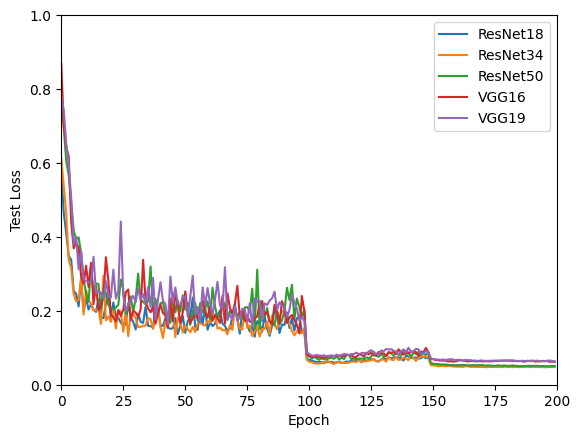

ResNet18 : Test Accuracy 95.15, Test Loss 0.1924
ResNet34 : Test Accuracy 95.28, Test Loss 0.2066
ResNet50 : Test Accuracy 95.03, Test Loss 0.2068
VGG16 : Test Accuracy 93.83, Test Loss 0.2942
VGG19 : Test Accuracy 93.69, Test Loss 0.3222


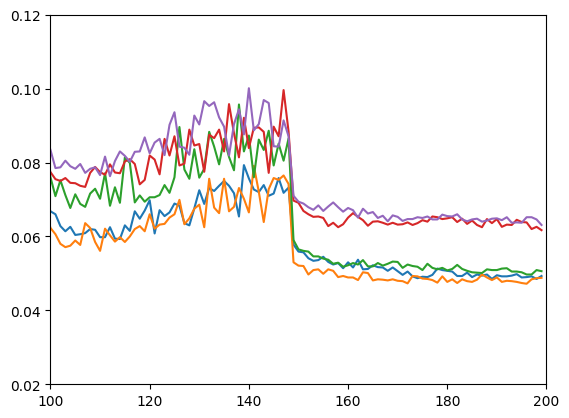

In [4]:
models = ["ResNet18","ResNet34","ResNet50", "VGG16", "VGG19"]
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 科学绘图常用的蓝色、橙色、绿色、红色和紫色

for idx, model in enumerate(models):
    path = f"/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/{model}/best_result/output.csv"
    df = pd.read_csv(path)

    plt.plot(1-df.val_acc, c=color[idx], label=f"{model}")


    max_val_acc = df.val_acc.max()
    max_val_loss = df[df.val_acc == max_val_acc]['val_loss'].values[0]
    print(model,":",f"Test Accuracy {max_val_acc*100:.2f},",f"Test Loss {max_val_loss:.4f}")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
# plt.yscale("log")
plt.ylim(0,1)
plt.xlim(0,200)
plt.show()


models = ["ResNet18","ResNet34","ResNet50", "VGG16", "VGG19"]
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 科学绘图常用的蓝色、橙色、绿色、红色和紫色

for idx, model in enumerate(models):
    path = f"/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/{model}/best_result/output.csv"
    df = pd.read_csv(path)

    plt.plot(1-df.val_acc, c=color[idx], label=f"{model}")


    max_val_acc = df.val_acc.max()
    max_val_loss = df[df.val_acc == max_val_acc]['val_loss'].values[0]
    print(model,":",f"Test Accuracy {max_val_acc*100:.2f},",f"Test Loss {max_val_loss:.4f}")

# plt.legend()
# plt.yscale("log")
plt.ylim(0.02,0.12)
plt.xlim(100,200)
plt.show()


### Params

In [5]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total trainable parameters: {total_params}")

vgg16_ = VGG16(residual=False, num_classes=10).to('cuda')
vgg19_ = VGG19(residual=False, num_classes=10).to('cuda')
Plain18_ = ResNet18(residual=False, num_classes=10).to('cuda')
Plain34_ = ResNet34(residual=False, num_classes=10).to('cuda')
Plain50_ = ResNet50(residual=False, num_classes=10).to('cuda')
ResNet18_ = ResNet18(residual=True, num_classes=10).to('cuda')
ResNet34_ = ResNet34(residual=True, num_classes=10).to('cuda')
ResNet50_ = ResNet50(residual=True, num_classes=10).to('cuda')

count_parameters(vgg16_)
count_parameters(vgg19_)
count_parameters(Plain18_)
count_parameters(Plain34_)
count_parameters(Plain50_)
count_parameters(ResNet18_)
count_parameters(ResNet34_)
count_parameters(ResNet50_)

Total trainable parameters: 14724042
Total trainable parameters: 20035018
Total trainable parameters: 11000138
Total trainable parameters: 21108298
Total trainable parameters: 20744266
Total trainable parameters: 11173962
Total trainable parameters: 21282122
Total trainable parameters: 23520842


### Thoughtput

In [6]:
import time
import torch
import torch.nn as nn

# 随机生成一个输入批次，用于测试吞吐量
batch_size = 128
input_shape = (3, 32, 32)  # CIFAR-10 的输入维度
device = 'cuda:3'

# 初始化模型
models = {
    "VGG16": VGG16(residual=True, num_classes=10).to(device),
    "VGG19": VGG19(residual=True, num_classes=10).to(device),
    "ResNet18": ResNet18(residual=True, num_classes=10).to(device),
    "ResNet34": ResNet34(residual=True, num_classes=10).to(device),
    "ResNet50": ResNet50(residual=True, num_classes=10).to(device)
}

paths={
    "VGG16": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/VGG16/best_result/model_best.pth",
    "VGG19": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/VGG19/best_result/model_best.pth",
    "ResNet18": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/best_result/model_best.pth",
    "ResNet34": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet34/best_result/model_best.pth",
    "ResNet50": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet50/best_result/model_best.pth"

}
# 加载权重
for model_name in models:
    checkpoint = torch.load(paths[model_name])
    # 移除"module."前缀
    new_state_dict = {}
    for k, v in checkpoint['state_dict'].items():
        name = k.replace("module.", "") 
        new_state_dict[name] = v
    models[model_name].load_state_dict(new_state_dict)
    models[model_name].eval()

# 定义吞吐量计算函数
def calculate_throughput(model, input_shape, batch_size=128, device='cuda', num_iterations=100):
    # 生成随机输入
    input_data = torch.randn(batch_size, *input_shape).to(device)
    # 确保在评估模式下
    model.eval()
    
    # GPU warm-up
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_data)
    
    # 开始测量
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_data)
    end_time = time.time()
    
    # 计算平均推理时间
    elapsed_time = end_time - start_time
    average_time_per_batch = elapsed_time / num_iterations
    
    # 计算吞吐量（每秒处理的样本数）
    throughput = batch_size / average_time_per_batch
    return throughput

# 计算每个模型的吞吐量
for model_name, model in models.items():
    throughput = calculate_throughput(model, input_shape, batch_size, device)
    print(f"{model_name} Throughput: {throughput:.2f} samples/second")

VGG16 Throughput: 71169.34 samples/second
VGG19 Throughput: 58441.10 samples/second
ResNet18 Throughput: 46043.07 samples/second
ResNet34 Throughput: 23218.57 samples/second
ResNet50 Throughput: 8508.99 samples/second


## Ablation Study (Validation)

### Learning Rate

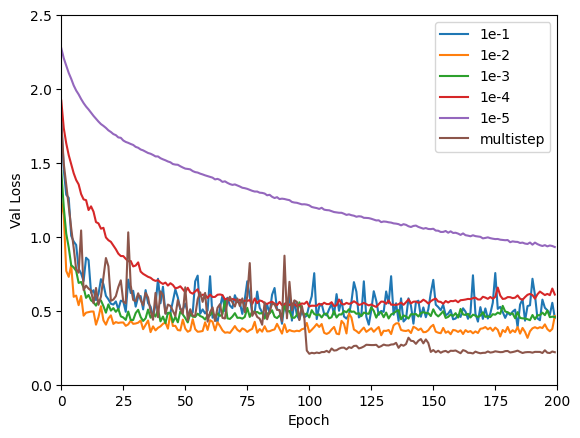

In [7]:


file_path = "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/ablation_study_validation_set/1_LearningRate/"

lr_lst = ["lr_1e1","lr_1e2","lr_1e3","lr_1e4","lr_1e5","multistep" ]
lr_name = ["1e-1", "1e-2", "1e-3", "1e-4","1e-5","multistep"]


for idx,lr in enumerate(lr_lst):
    path = file_path + lr +"/output.csv"
    df = pd.read_csv(path)
    plt.plot(df.val_loss,label=lr_name[idx])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
# plt.yscale("log")
plt.ylim(0,2.5)
plt.xlim(0,200)
plt.show()

### Weight Decay

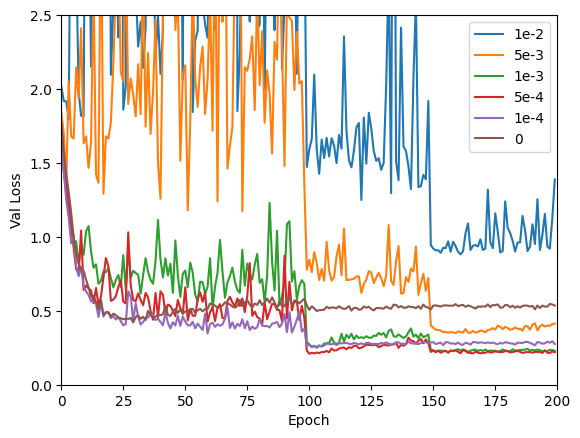

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/ablation_study_validation_set/2_WeightDecay/weight_decay_"

wd_lst = ["1e2","5e3", "1e3","5e4","1e4","0"]
wd_name = ["1e-2","5e-3", "1e-3","5e-4","1e-4","0"]


for idx,lr in enumerate(wd_lst):
    path = file_path + lr +"/output.csv"
    df = pd.read_csv(path)
    plt.plot(df.val_loss,label=wd_name[idx])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
# plt.yscale("log")
plt.ylim(0,2.5)
plt.xlim(0,200)
plt.show()

### Momentum

In [9]:
m_off_path = "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/ablation_study_validation_set/3_Momentum/momentum_off/output.csv"
m_on_path = "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/ablation_study_validation_set/3_Momentum/momentum_on/output.csv"

m_off = pd.read_csv(m_off_path)
m_on = pd.read_csv(m_on_path)

print("Momentum Off:",f"{m_off.loc[m_off['val_acc'].idxmax()].val_acc*100:.2f}")
print("Momentum On:",f"{m_on.loc[m_on['val_acc'].idxmax()].val_acc*100:.2f}")

Momentum Off: 93.23
Momentum On: 94.61


### Residual

In [10]:
r_off_path = "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/ablation_study_validation_set/4_Residual/residual_off/output.csv"
r_on_path = "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/ablation_study_validation_set/4_Residual/residual_on/output.csv"

r_off = pd.read_csv(r_off_path)
r_on = pd.read_csv(r_on_path)

print("Residual Off:",f"{r_off.loc[r_off['val_acc'].idxmax()].val_acc*100:.2f}")
print("Residual On:",f"{r_on.loc[r_on['val_acc'].idxmax()].val_acc*100:.2f}")

Residual Off: 94.02
Residual On: 94.61


### Augmentation

In [11]:
aug_path = "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/ablation_study_validation_set/5_Augmentation"
augs = [file for file in os.listdir(aug_path)]

for aug in augs:
    path = f"/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/ablation_study_validation_set/5_Augmentation/{aug}/output.csv"
    df = pd.read_csv(path)
    print(aug.split("_") if aug != "No_Aug" else ["None"], ":", f"{df.loc[df['val_acc'].idxmax()].val_acc*100:.2f}")

['None'] : 87.13
['RandomCrop'] : 92.89
['RandomCrop', 'RandomHorizontalFlip'] : 94.61
['RandomHorizontalFlip'] : 90.66
['RandomHorizontalFlip', 'RandomCrop'] : 94.23


## Residual Analysis (Test)

W/ Test Acc: 95.15 . W/o Test Acc: 94.98


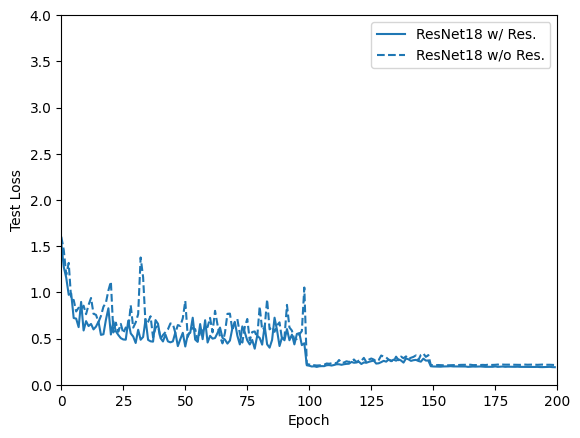

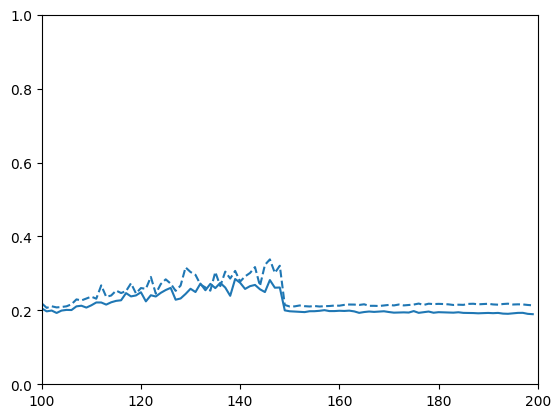

W/ Test Acc: 95.28 . W/o Test Acc: 93.51


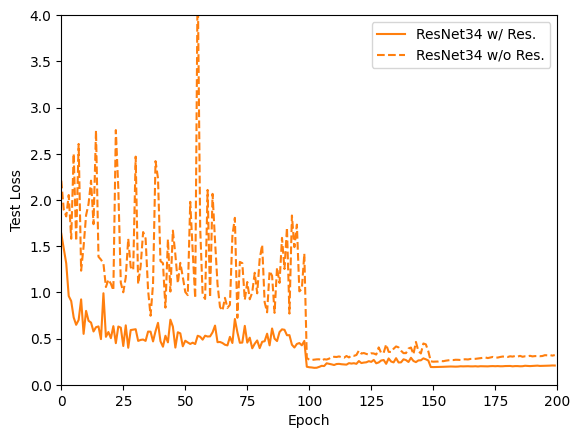

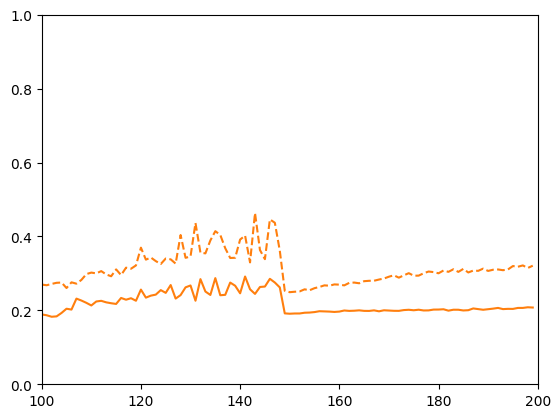

W/ Test Acc: 95.03 . W/o Test Acc: 90.67


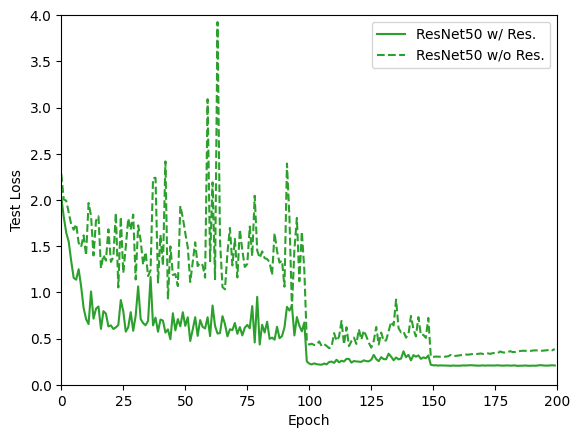

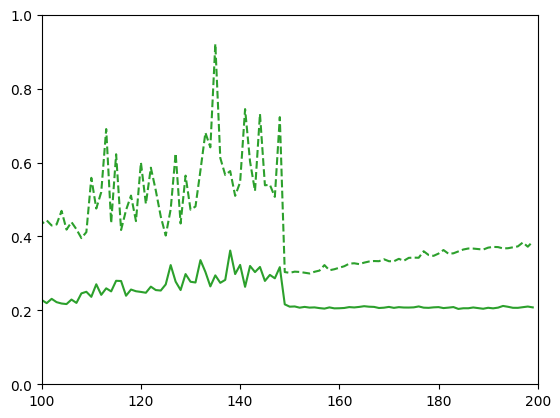

In [12]:
models = ["ResNet18","ResNet34","ResNet50"]
color = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 科学绘图常用的蓝色、橙色和绿色

for idx, model in enumerate(models):
    w_residual_path = f"/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/{model}/best_result/output.csv"
    wo_residual_path = f"/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/{model}/test_residual_off/output.csv"
    df_w = pd.read_csv(w_residual_path)
    df_wo = pd.read_csv(wo_residual_path)

    print("W/ Test Acc:", df_w.val_acc.max()*100, ". W/o Test Acc:", df_wo.val_acc.max()*100)
    plt.plot(df_w.val_loss, c=color[idx], label=f"{model} w/ Res.")
    plt.plot(df_wo.val_loss, c=color[idx], linestyle='--', label=f"{model} w/o Res.")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Test Loss")
    plt.xlim(0,200)
    plt.ylim(0,4)
    plt.show()

    plt.plot(df_w.val_loss, c=color[idx], label=f"{model} w/ Res.")
    plt.plot(df_wo.val_loss, c=color[idx], linestyle='--', label=f"{model} w/o Res.")
    plt.xlim(100,200)
    plt.ylim(0,1)
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
(0.21458556861877442, 0.9498)
(0.19240031101703645, 0.9515)
(0.30864745988845826, 0.9351)
(0.20655074257850647, 0.9528)
(0.3043812159061432, 0.9067)
(0.20682370433807373, 0.9503)


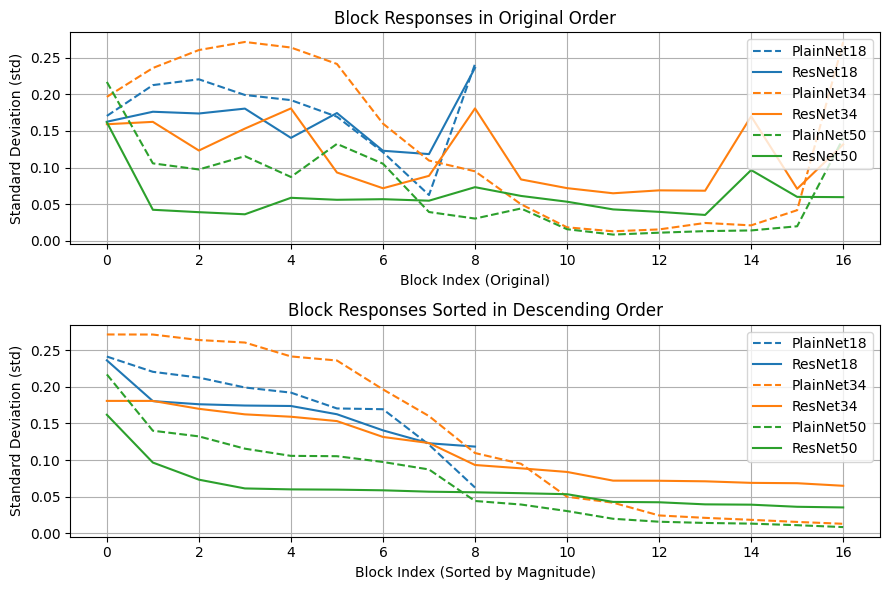

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F

# 定义评估函数
# Modify the function to calculate standard deviation instead of mean
def get_layer_output_stds(model, loader):
    output_stds = {}

    # Define hook function to compute standard deviation
    def save_output(name):
        def hook(module, input, output):
            if isinstance(module, torch.nn.BatchNorm2d) and "shortcut" not in name:  # Focus on non-shortcut convolution layers
                output_stds[name] = output.std().item()  # Calculate std directly
        return hook

    # Register hook for each layer
    for name, layer in model.named_modules():
        layer.register_forward_hook(save_output(name))

    # Forward pass on a single batch
    for i, (X, y) in enumerate(loader):
        X = X.to('cuda')
        _ = model(X)
        break  # Only one forward pass

    return list(output_stds.values())

# 加载数据
train_loader, test_loader, _ = get_loaders(
    dir_="/home/sukyeong/Project/DL_Assignment2/data", 
    batch_size=128, 
    dataset="cifar10", 
    worker=4, 
    augs="", 
    validation=False
)


paths={
    "PlainNet18": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/test_residual_off/model_best.pth",
     "ResNet18": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet18/best_result/model_best.pth",
    "PlainNet34": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet34/test_residual_off/model_best.pth",
    "ResNet34": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet34/best_result/model_best.pth",
    "PlainNet50": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet50/test_residual_off/model_best.pth",
    "ResNet50": "/home/sukyeong/Project/DL_Assignment2/ckpt/cifar10/ResNet50/best_result/model_best.pth"

}
# 初始化模型
models = {
    "PlainNet18": ResNet18(residual=False, num_classes=10).to('cuda'),
    "ResNet18": ResNet18(residual=True, num_classes=10).to('cuda'),
    "PlainNet34": ResNet34(residual=False, num_classes=10).to('cuda'),
    "ResNet34": ResNet34(residual=True, num_classes=10).to('cuda'),
    "PlainNet50": ResNet50(residual=False, num_classes=10).to('cuda'),
    "ResNet50": ResNet50(residual=True, num_classes=10).to('cuda')
}

# 加载权重
for model_name in models:
    checkpoint = torch.load(paths[model_name])
    # 移除"module."前缀
    new_state_dict = {}
    for k, v in checkpoint['state_dict'].items():
        name = k.replace("module.", "") 
        new_state_dict[name] = v
    models[model_name].load_state_dict(new_state_dict)
    models[model_name].eval()
    print(evaluate_standard(test_loader, models[model_name]))


# Get std values for each model
std_values = {}
for name, model in models.items():
    if "18" in name or "34" in name:
        std_values[name] = get_layer_output_stds(model, train_loader)[::2]  # Every 2nd layer for ResNet18 and ResNet34
    elif "50" in name:
        std_values[name] = get_layer_output_stds(model, train_loader)[::3]  # Every 3rd layer for ResNet50

# Plotting
plt.figure(figsize=(9, 6))


plt.subplot(2, 1, 1)
colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c']  # 每对模型使用相同颜色
linestyles = ['--', '-', '--', '-', '--', '-']  # Plain用虚线,Res用实线
for (name, stds), color, ls in zip(std_values.items(), colors, linestyles):
    plt.plot(stds, label=name, color=color, linestyle=ls)
plt.xlabel('Block Index (Original)')
plt.ylabel('Standard Deviation (std)')
plt.title('Block Responses in Original Order')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for (name, stds), color, ls in zip(std_values.items(), colors, linestyles):
    plt.plot(sorted(stds, reverse=True), label=name, color=color, linestyle=ls)
plt.xlabel('Block Index (Sorted by Magnitude)')
plt.ylabel('Standard Deviation (std)')
plt.title('Block Responses Sorted in Descending Order')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()